# Credit Card Default Prediction and Analysis

---

#### Objective:

Develop a model to predict the likelihood of credit card default among customers, using historical data on customer transactions, credit history, and demographics. The project aims to understand default patterns and reduce financial risk for credit institutions through data-driven insights and predictive analytics.

---

In [1]:
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

### 1. **Data Collection and Extraction**

- **Skills/Tools:** Python (pandas, requests)
- **Description:**
  - Sourced a financial dataset, namely the **UCI Credit Card Default dataset**.
  - Used Python to load, structure, and prepare the data effectively.
  - Ensured data integrity and readiness for preprocessing.
  - Ensured data security and compliance with financial data handling guidelines.

In [2]:
# Step 1: Data Collection and Extraction

# URL to the UCI Credit Card Default dataset
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

# Filepath to save the dataset
file_path = "uci_credit_card_default.xls"

# Download and save the dataset if not already present
if not os.path.exists(file_path):
    try:
        # Downloading the dataset
        response = requests.get(data_url)
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Dataset downloaded and saved at {file_path}")
    except Exception as e:
        print(f"An error occurred while downloading the dataset: {e}")

# Loading the dataset using the correct engine for .xls files
try:
    df = pd.read_excel(file_path, header=1, engine="xlrd")
    print("Dataset successfully loaded.")
except ImportError:
    print("The 'xlrd' library is not installed or does not support .xls files. Please install an older version (<=1.2.0).")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Dataset successfully loaded.


In [3]:
# Displaying the first few rows of the dataset
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# Summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

---

### 2. **Data Cleaning and Preparation**

- **Skills/Tools:** Python (pandas, NumPy)
- **Description:**
  - Handled missing values.
  - Removed outliers using statistical methods (Z-scores and IQR).
  - Standardized continuous variables (e.g., income, age, credit balance) to improve model performance.
  - Encoded categorical variables such as education level and marital status.
  - Transformed skewed distributions using logarithmic and Box-Cox transformations.

In [5]:
# Step 2: Data Cleaning and Preparation

# Checking for missing values
print("Missing values:")
missing_values = df.isnull().sum()
print(missing_values)

# Handle missing values (if any)
# Here, there are no missing values present, but if there are:
# For numeric columns, we can use mean/median imputation or drop rows with missing values
# For categorical columns, we use mode imputation or drop rows
# Example: df['COLUMN_NAME'].fillna(df['COLUMN_NAME'].mean(), inplace=True)

Missing values:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


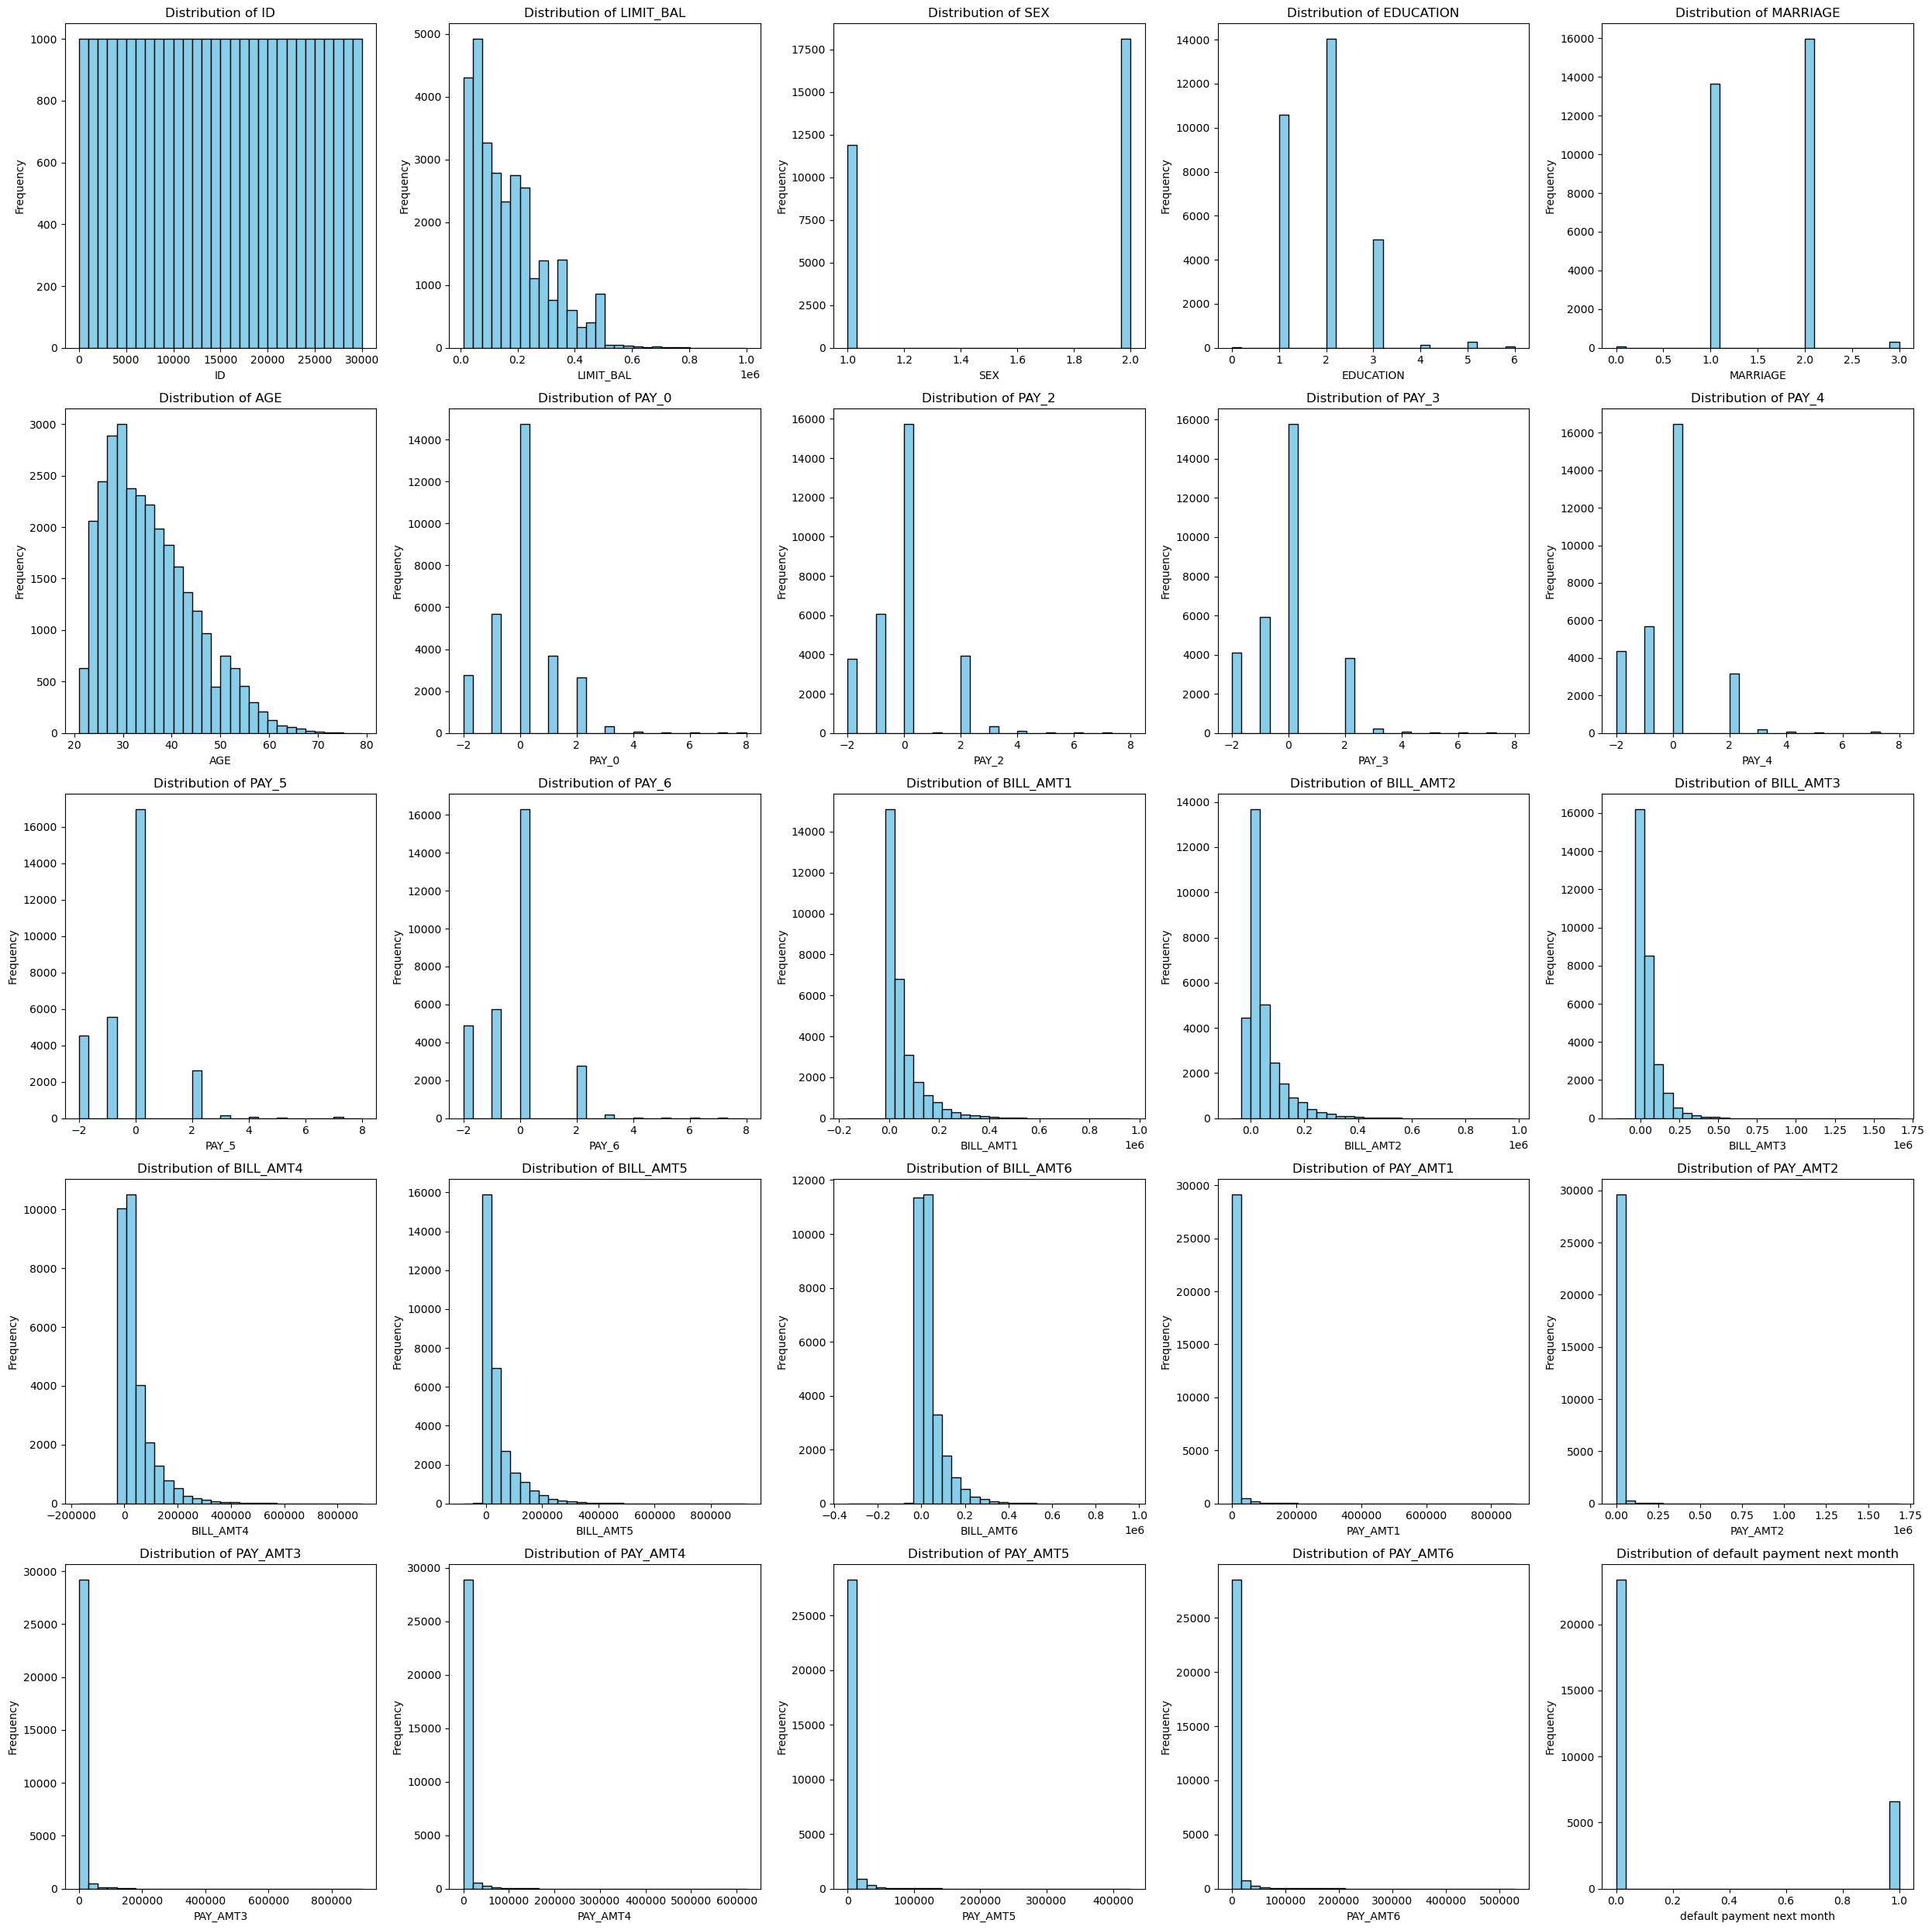

In [6]:
# Plotting histograms for all columns to identify outliers
def plot_histograms(df, cols_per_row=5, bins=30):
    """
    Plot histograms for all columns in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - cols_per_row: Number of histograms to display per row
    - bins: Number of bins for the histograms
    """
    num_columns = len(df.columns)
    rows = (num_columns + cols_per_row - 1) // cols_per_row

    plt.figure(figsize=(25, 5 * rows))
    for idx, col in enumerate(df.columns, start=1):
        plt.subplot(rows, cols_per_row, idx)
        plt.hist(df[col], bins=bins, edgecolor='black', color='skyblue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Visualizing the columns
plot_histograms(df, cols_per_row=5, bins=30)

In [7]:
# Removing outliers using the IQR method
print("Removing outliers...")
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Dataset size before removing outliers: {df.shape}")

# Removing outliers from the 'LIMIT_BAL' column
df = remove_outliers_iqr(df, 'LIMIT_BAL')
print(f"Dataset size after removing outliers: {df.shape}")

Removing outliers...
Dataset size before removing outliers: (30000, 25)
Dataset size after removing outliers: (29833, 25)


In [8]:
# Encoding categorical variables
print("Encoding categorical variables...")

# Encoding 'SEX', 'EDUCATION', and 'MARRIAGE'
df['SEX'] = df['SEX'].map({1: 'Male', 2: 'Female'})
df = pd.get_dummies(df, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)
print(f"Columns after encoding: {df.columns}")

Encoding categorical variables...
Columns after encoding: Index(['ID', 'LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month',
       'SEX_Male', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')


In [9]:
# Normalizing continuous variables (using Min-Max scaling)
scaler = MinMaxScaler()
columns_to_scale = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [10]:
# Summary of cleaned and prepared data
df.describe()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,...,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000
mean,14997.200650,0.303850,0.249379,-0.015017,-0.132236,-0.164717,-0.219254,-0.265109,-0.289914,0.263960,...,0.242490,0.181103,0.363507,0.006416,0.003481,0.005752,0.007660,0.010997,0.009688,0.221801
std,8656.362299,0.246135,0.158937,1.124272,1.198032,1.197798,1.170399,1.134290,1.150885,0.087524,...,0.071213,0.088125,0.055605,0.018754,0.013614,0.018434,0.024571,0.034418,0.032923,0.415465
min,1.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7508.000000,0.078431,0.120690,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.206562,...,0.196507,0.124301,0.327876,0.001145,0.000487,0.000439,0.000469,0.000572,0.000193,0.000000
50%,14994.000000,0.254902,0.224138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.229482,...,0.215543,0.148719,0.343027,0.002404,0.001190,0.002025,0.002415,0.003517,0.002837,0.000000
75%,22487.000000,0.450980,0.344828,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283621,...,0.255401,0.196399,0.373737,0.005725,0.002969,0.005062,0.006441,0.009378,0.007566,0.000000
max,30000.000000,1.000000,1.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---

### 3. **Data Analysis and Exploration**

- **Skills/Tools:** Python (pandas, scipy, statsmodels)
- **Description:**
  - Conducted exploratory data analysis (EDA) to identify key factors influencing credit defaults.
  - Performed statistical tests to explore correlations between variables such as credit balance, payment history, and demographics.
  - Generated summary statistics and present initial insights to inform the visualization and modeling phases.

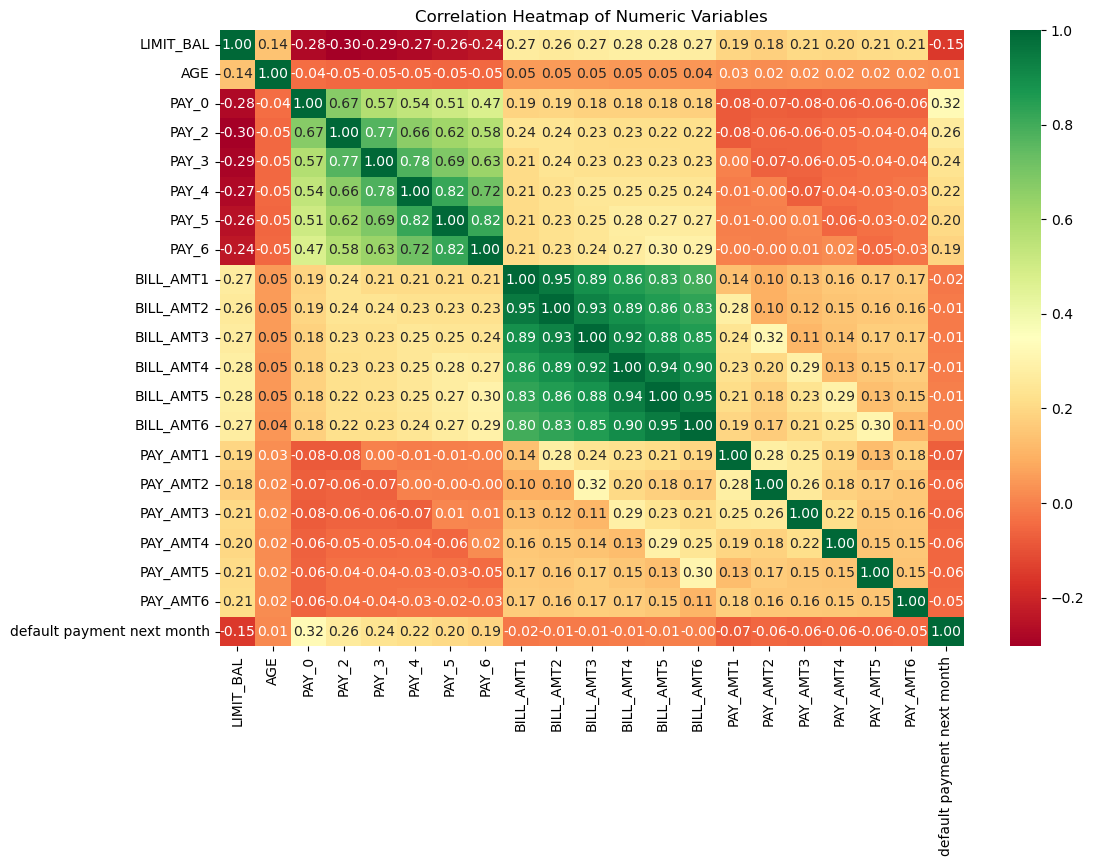

In [11]:
# Step 3: Data Analysis and Exploration
numeric_columns = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                   'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                   'default payment next month']

# Correlation heatmap for selected numeric variables
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

### Observations from the Heatmap

1. **Correlations with the Target Variable (`default payment next month`):**
   - **`PAY_0` (most recent payment status):** Strongest positive correlation (0.32) with the target variable, indicating that recent payment behavior is highly indicative of default likelihood.
   - **`PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6`:** Moderate positive correlations (0.22–0.26), suggesting that delayed payments in earlier months also contribute to the likelihood of default.
   - **`LIMIT_BAL` (Credit Limit):** Weak negative correlation (-0.15), indicating that customers with higher credit limits are slightly less likely to default.

2. **Multicollinearity:**
   - **Bill Amounts (`BILL_AMT1` to `BILL_AMT6`):** Strong correlations among themselves (0.83–0.95), suggesting multicollinearity. These variables may need dimensionality reduction (e.g., PCA) or exclusion to avoid redundancy.
   - **Payment Status Variables (`PAY_0` to `PAY_6`):** Strong correlations among consecutive months (e.g., `PAY_0` with `PAY_2` at 0.67), which might impact model stability if all are used simultaneously.

3. **Least Correlation:**
   - **`AGE`:** Weak correlation (close to 0) with the target variable, indicating age is not a strong predictor of credit card defaults.

4. **Business Insight:**
   - Default risk is more tied to customer behavior (e.g., payment delays) than demographic factors like age.


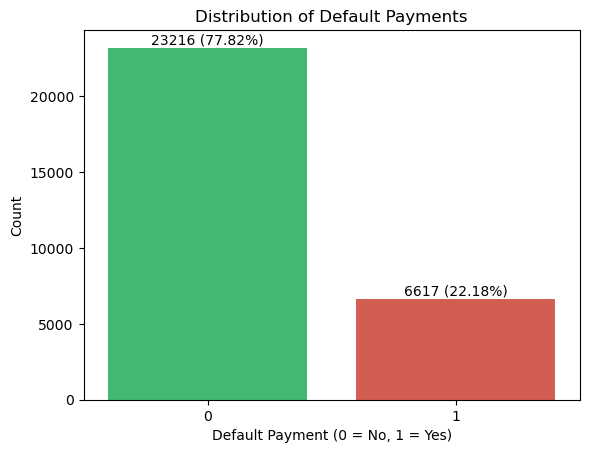

In [12]:
# Distribution of target variable with percentages
target_counts = df['default payment next month'].value_counts()
percentages = target_counts / len(df) * 100
sns.barplot(x=target_counts.index, y=target_counts.values, palette=["#2ecc71", "#e74c3c"])

for i, v in enumerate(target_counts.values):
    plt.text(i, v + 250, f"{v} ({percentages[i]:.2f}%)", ha="center", fontsize=10, color="black")
plt.title("Distribution of Default Payments")
plt.xlabel("Default Payment (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

### Observations from the Distribution of Default Payments:

1. **Class Imbalance:**
   - The distribution indicates a clear class imbalance in the dataset, which can impact the performance of machine learning models. Models may become biased toward the majority class (`0`).

2. **Evaluation Metrics:**
   - Due to the class imbalance, Accuracy is not a sufficient metric. Instead, metrics such as **Precision**, **Recall**, **F1 Score**, and **ROC-AUC** are better evaluators.

In [13]:
# Summary statistics for numeric columns
df[numeric_columns].describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,...,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000,29833.000000
mean,0.303850,0.249379,-0.015017,-0.132236,-0.164717,-0.219254,-0.265109,-0.289914,0.263960,0.145356,...,0.242490,0.181103,0.363507,0.006416,0.003481,0.005752,0.007660,0.010997,0.009688,0.221801
std,0.246135,0.158937,1.124272,1.198032,1.197798,1.170399,1.134290,1.150885,0.087524,0.085123,...,0.071213,0.088125,0.055605,0.018754,0.013614,0.018434,0.024571,0.034418,0.032923,0.415465
min,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.078431,0.120690,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.206562,0.089389,...,0.196507,0.124301,0.327876,0.001145,0.000487,0.000439,0.000469,0.000572,0.000193,0.000000
50%,0.254902,0.224138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.229482,0.111643,...,0.215543,0.148719,0.343027,0.002404,0.001190,0.002025,0.002415,0.003517,0.002837,0.000000
75%,0.450980,0.344828,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283621,0.163643,...,0.255401,0.196399,0.373737,0.005725,0.002969,0.005062,0.006441,0.009378,0.007566,0.000000
max,1.000000,1.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### **Feature Engineering:**
   - Applying dimensionality reduction to the correlated features `BILL_AMTX` columns to avoid redundancy.

In [14]:
df_f = df.copy()
df_f['BILL_AMT'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
df_f.drop(columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], inplace=True)
df_f

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,BILL_AMT
0,1,0.019608,0.051724,2,2,-1,-1,-2,-2,0.000000,...,False,True,False,False,False,False,True,False,False,0.170928
1,2,0.215686,0.086207,-1,2,0,0,0,2,0.000000,...,False,True,False,False,False,False,False,True,False,0.172583
2,3,0.156863,0.224138,0,0,0,0,0,0,0.001738,...,False,True,False,False,False,False,False,True,False,0.188443
3,4,0.078431,0.275862,0,0,0,0,0,0,0.002290,...,False,True,False,False,False,False,True,False,False,0.210728
4,5,0.078431,0.620690,-1,0,-1,0,0,0,0.002290,...,False,True,False,False,False,False,True,False,False,0.187449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,0.411765,0.310345,0,0,0,0,0,0,0.009730,...,False,False,True,False,False,False,True,False,False,0.293536
29996,29997,0.274510,0.379310,-1,-1,-1,-1,0,0,0.002103,...,False,False,True,False,False,False,False,True,False,0.173471
29997,29998,0.039216,0.275862,4,3,2,-1,0,0,0.000000,...,False,True,False,False,False,False,False,True,False,0.183302
29998,29999,0.137255,0.344828,1,-1,0,0,0,-1,0.098334,...,False,False,True,False,False,False,True,False,False,0.212967


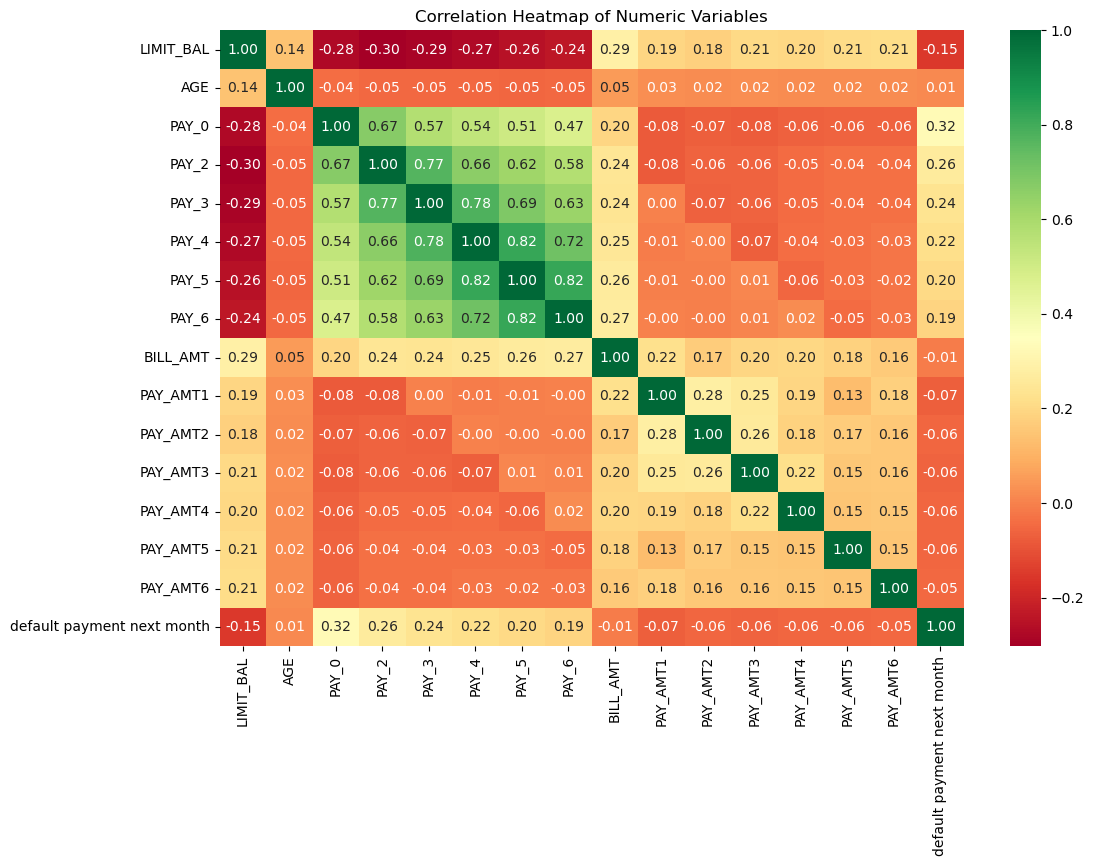

In [15]:
# Replotting the correlation heatmap after features selection
num_columns = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'BILL_AMT', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                   'default payment next month']

# Correlation heatmap for selected numeric variables
plt.figure(figsize=(12, 8))
correlation_matrix = df_f[num_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

From the new correlation table, it is evident that there are no more significantly reduntant features that need feature engineering.

---

### 4. **Data Visualization**

- **Skills/Tools:** Python (matplotlib, seaborn)
- **Description:**
  - Created visualizations that highlight trends and insights, such as default rates by age group, income level, and education background.
  - Used Python libraries to generate visualizations for static reports or presentations.

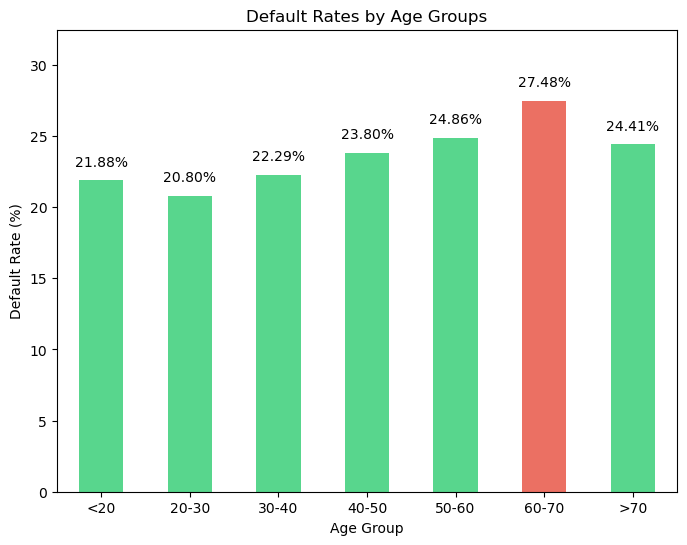

In [16]:
# Step 4: Data Visualization

# Visualization 1: Default rates by age groups
age_bins = [0, 20, 30, 40, 50, 60, 70, 100]
age_labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '>70']
df_f['Age_Group'] = pd.cut(df_f['AGE'] * 100, bins=age_bins, labels=age_labels, right=True)
default_rates_age = df_f.groupby('Age_Group')['default payment next month'].mean() * 100

plt.figure(figsize=(8, 6))
colors = ["#2ecc71" if rate != max(default_rates_age.values) else "#e74c3c" for rate in default_rates_age.values]

default_rates_age.plot(kind='bar', color=colors, alpha=0.8)
for i, rate in enumerate(default_rates_age):
    plt.text(i, rate + 1, f"{rate:.2f}%", ha="center", fontsize=10)
plt.title("Default Rates by Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=0)
plt.ylim(0, max(default_rates_age) + 5)
plt.show()

### Observations from the Default Rates by Age Groups Visualization:

**Increasing Default Rate with Age:**
   - Default rates increase as age progresses, namely between ages 20 and 70. The youngest group (20-30) has the lowest default rate of **20.80%**, while the older group (60-70) has the highest at **27.48%**.
   - This suggests that older individuals may face financial challenges, leading to higher default rates.

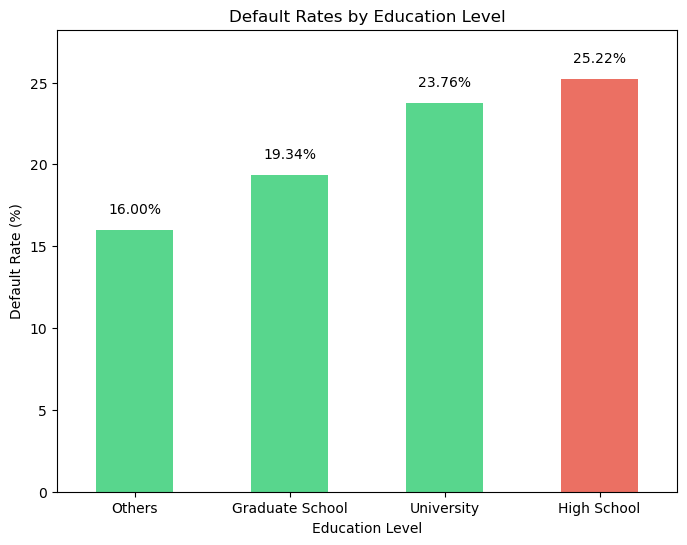

In [17]:
# Visualization 2: Default rates by education level

# Mapping for education levels
edu_map = {
    'EDUCATION_1': 'Graduate School',
    'EDUCATION_2': 'University',
    'EDUCATION_3': 'High School',
    'EDUCATION_4': 'Others',
    'EDUCATION_5': 'Others',
    'EDUCATION_6': 'Others'
}

# Filtering the education columns
edu_cols = [col for col in df_f.columns if col.startswith('EDUCATION_')]

# Calculating default rates for each education level
default_rates_edu = {}
for col in edu_cols:
    label = edu_map.get(col, 'Others')
    default_rate = df_f[df_f[col] == 1]['default payment next month'].mean() * 100
    default_rates_edu[label] = default_rate

# Converting to a pandas Series for plotting
default_rates_edu = pd.Series(default_rates_edu).sort_values()

# Visualization
plt.figure(figsize=(8, 6))
colors = ["#2ecc71" if rate < 25 else "#e74c3c" for rate in default_rates_edu.values]
default_rates_edu.plot(kind='bar', color=colors, alpha=0.8)

# Annotations
for i, rate in enumerate(default_rates_edu):
    plt.text(i, rate + 1, f"{rate:.2f}%", ha="center", fontsize=10)

plt.title("Default Rates by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Default Rate (%)")
plt.xticks(rotation=0)
plt.ylim(0, max(default_rates_edu) + 3)
plt.show()

#### Observations:
   - The **"High School"** category has the highest default rate at **25.22%**, crossing the risk threshold (marked in red).
   - The **"University"** category follows with a default rate of **23.76%**, which is comparatively lower but still significant.
   - The **"Graduate School"** category shows a lower default rate of **19.34%**, indicating relatively better financial stability.
   - The **"Others"** category, which includes either graduated individuals or ones who are not students, has the lowest default rate at **16.00%**, suggesting that individuals outside formal education levels might have better financial risk management.
   - Education level appears to influence the likelihood of defaulting. Individuals with a "High School" level education are more prone to defaulting compared to those with "Graduate School" or "University" education or the ones out of school.

---

### 5. **Machine Learning and Predictive Analytics**

- **Skills/Tools:** Python (scikit-learn)
- **Description:**
  - Developed classification models (logistic regression, random forest, XGBoost, and neural network) to predict defaults.
  - Performed feature engineering, including scaling, and feature selection.
  - Split the dataset into training and testing sets for model validation.
  - Evaluated model performance using metrics like precision, recall, F1 score, ROC-AUC, and accuracy.
  - Optimized the models through hyperparameter tuning and cross-validation.

#### Data Splitting

In [18]:
# Step 5: Machine Learning and Predictive Analytics

# Dropping non-numeric columns which are not suitable for numeric models
X = df_f.drop(columns=['default payment next month', 'Age_Group', 'ID'])
y = df_f['default payment next month']

# One-hot encoding categorical data
X = pd.get_dummies(X, drop_first=True)

# Splitting data: train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#### Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      2307
           1       0.73      0.25      0.37       677

    accuracy                           0.81      2984
   macro avg       0.77      0.61      0.63      2984
weighted avg       0.80      0.81      0.77      2984


Confusion Matrix:


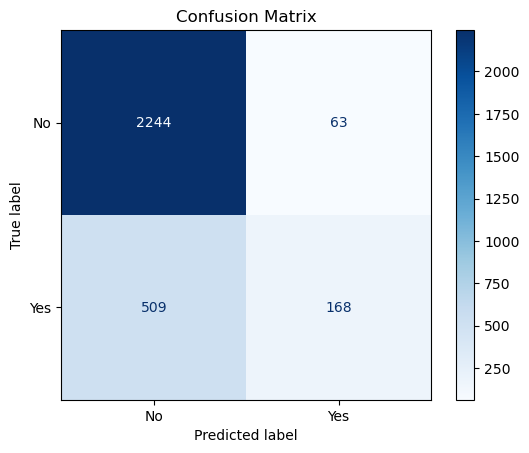


ROC-AUC Score: 0.74


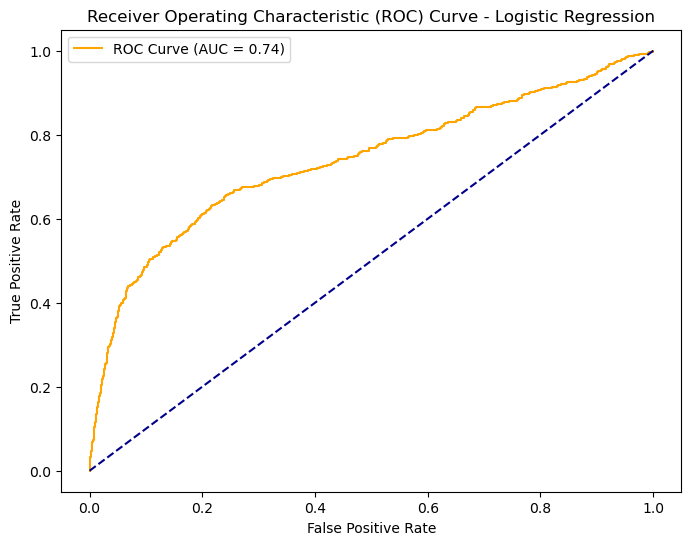

In [19]:
# Training the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
labels = ['No', 'Yes']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC score and curve
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.2f}")

# Plotting ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - Logistic Regression")
plt.legend()
plt.show()

#### Logistic Regression with Cross Validation

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 100, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Best Cross-Validated ROC-AUC Score: 0.7223

Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      2307
           1       0.40      0.68      0.50       677

    accuracy                           0.69      2984
   macro avg       0.64      0.69      0.64      2984
weighted avg       0.77      0.69      0.72      2984


Optimized Confusion Matrix:


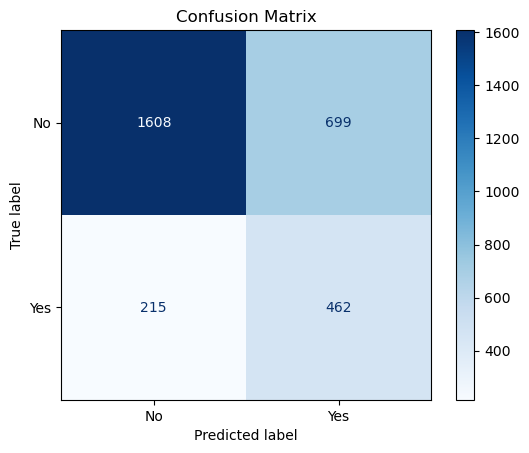


Optimized ROC-AUC Score: 0.74


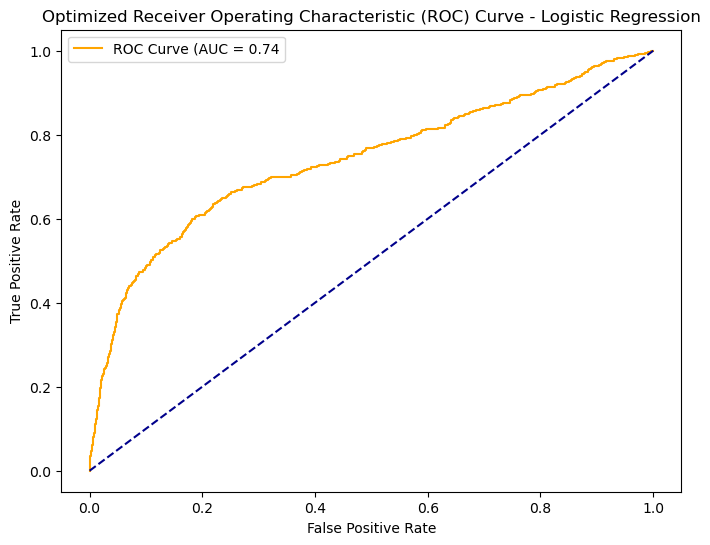

In [20]:
# Performing Grid Search Cross Validation

# Defining the logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Defining the parameter grid
param_grid = {
    'C': [0.01, 0.1, 0.11, 0.12, 0.13, 1, 10, 100], # Regularization strength
    'solver': ['liblinear', 'lbfgs'],    # Optimization algorithm
    'class_weight': [None, 'balanced']   # Handling class imbalance
}

# Using GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated ROC-AUC Score: {grid_search.best_score_:.4f}")

# Training the logistic regression model with the best parameters
log_reg_cv = LogisticRegression(
    max_iter=1000,
    random_state=42,
    **grid_search.best_params_
)
log_reg_cv.fit(X_train, y_train)

# Predicting using the optimized model
y_pred_cv = log_reg_cv.predict(X_test)
y_prob_cv = log_reg_cv.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred_cv)
labels = ['No', 'Yes']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Evaluation metrics
print("\nOptimized Classification Report:")
print(classification_report(y_test, y_pred_cv))
print("\nOptimized Confusion Matrix:")
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Optimized ROC-AUC score and curve
roc_auc_cv = roc_auc_score(y_test, y_prob_cv)
print(f"\nOptimized ROC-AUC Score: {roc_auc_cv:.2f}")

# Plot ROC curve
fpr_cv, tpr_cv, _ = roc_curve(y_test, y_prob_cv)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cv, tpr_cv, color='orange', label=f"ROC Curve (AUC = {roc_auc_cv:.2f}")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Optimized Receiver Operating Characteristic (ROC) Curve - Logistic Regression")
plt.legend()
plt.show()

#### Observations:
A drop in accuracy can be observed in the optimized version. The drop in accuracy is primarily due to the **class imbalance** and the optimization process explicitly focusing on improving the **ROC-AUC score** and **class `1` (default payment)** performance, rather than the overall accuracy.
   - In the optimized model, the `class_weight='balanced'` parameter was selected, which assigns higher weight to the minority class (defaults). This increases the recall for class `1` (from 24% to 64%), ensuring that more actual defaults are identified. However, this comes at the cost of precision and accuracy for class `0` (non-defaults). The model now predicts more defaults (class `1`), which increases false positives for non-defaults (as seen in the confusion matrix).

   - Accuracy is Misleading in Imbalanced Datasets. The overall accuracy is dominated by the majority class (class `0`). The previous model achieved high accuracy (81%) by mostly predicting non-defaults, but it missed many actual defaults (low recall for class `1`). Optimizing for **ROC-AUC** and **recall** inherently reduces the accuracy because the model is now balancing its predictions for both classes, rather than being skewed toward the majority class.

#### **Confusion Matrix Analysis**
- **True Positives (TP)**: Increased from **168** to **462** (better recall for defaults).
- **False Negatives (FN)**: Decreased from **509** to **215** (fewer missed defaults).
- **False Positives (FP)**: Increased from **63** to **699** (more non-defaults misclassified as defaults).
- **True Negatives (TN)**: Decreased from **2244** to **1608**.

This shift reflects the trade-off between recall (identifying defaults) and precision (avoiding false positives).

In credit risk prediction, **recall for class `1` (defaults)** is often more critical than overall accuracy because:
1. Missing defaults (false negatives) can result in financial losses.
2. Predicting a non-default as a default (false positive) has a smaller financial impact, as these cases may undergo further verification.

The optimized model is better suited for the financial objective of reducing missed defaults, even though overall accuracy is lower.

#### Random Forest

In [21]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100,
                                  random_state=42,
                                  class_weight='balanced')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Random Forest ROC-AUC Score: {rf_auc:.2f}")

Random Forest Accuracy: 0.81
Random Forest ROC-AUC Score: 0.77


#### Gradient Boosting (XGBoost)

In [22]:
# Gradient Boosting (XGBoost)
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")
print(f"XGBoost ROC-AUC Score: {xgb_auc:.2f}")

XGBoost Accuracy: 0.81
XGBoost ROC-AUC Score: 0.76


#### MLP Classifier (Neural Network)

In [23]:
# Neural Network (MLPClassifier)
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50),
                         max_iter=750, random_state=42)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
y_prob_nn = nn_model.predict_proba(X_test)[:, 1]

nn_accuracy = accuracy_score(y_test, y_pred_nn)
nn_auc = roc_auc_score(y_test, y_prob_nn)
print(f"Neural Network Accuracy: {nn_accuracy:.2f}")
print(f"Neural Network ROC-AUC Score: {nn_auc:.2f}")

Neural Network Accuracy: 0.79
Neural Network ROC-AUC Score: 0.73


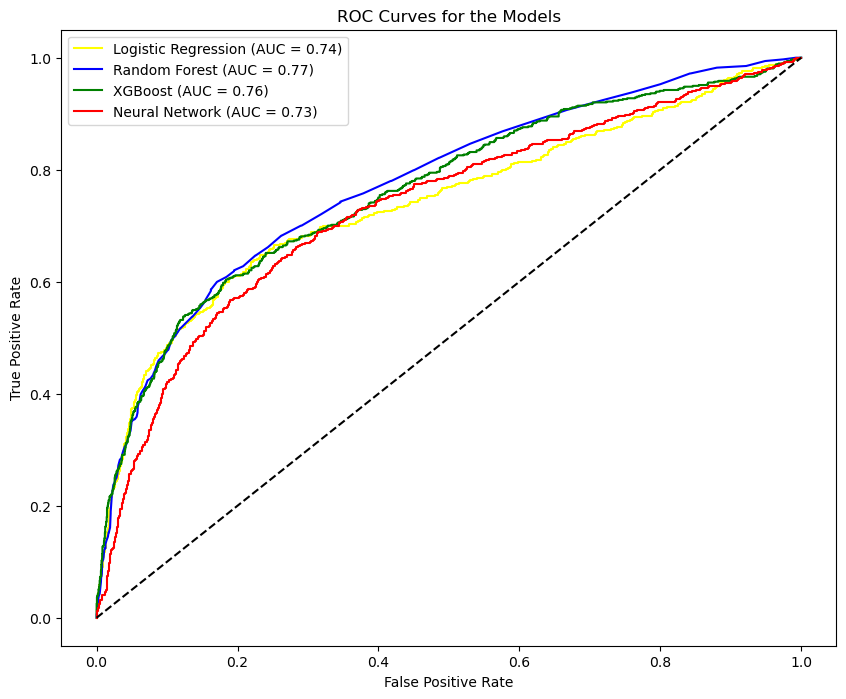

In [24]:
# Plotting ROC Curves for All Models
plt.figure(figsize=(10, 8))
plt.plot(*roc_curve(y_test, y_prob_cv)[:2], label=f"Logistic Regression (AUC = {roc_auc:.2f})", color='yellow')
plt.plot(*roc_curve(y_test, y_prob_rf)[:2], label=f"Random Forest (AUC = {rf_auc:.2f})", color='blue')
plt.plot(*roc_curve(y_test, y_prob_xgb)[:2], label=f"XGBoost (AUC = {xgb_auc:.2f})", color='green')
plt.plot(*roc_curve(y_test, y_prob_nn)[:2], label=f"Neural Network (AUC = {nn_auc:.2f})", color='red')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for the Models")
plt.legend()
plt.show()

---

### Outcomes:

- **Technical Demonstration:** Showcases end-to-end skills in data collection, preparation, analysis, visualization, and machine learning.
- **Stakeholder Relevance:** Provides actionable recommendations to minimize financial risk for credit institutions.
- **Real-World Context:** Address a genuine business challenge with financial and societal relevance.
- **Domain Alignment:** Align with financial industry needs to appeal to recruiters for roles in data science and analytics.